In [11]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
from torch.optim import SGD
from torch.optim.lr_scheduler import ChainedScheduler, CosineAnnealingLR, LinearLR

from ssd import SSD
from ssd.structs import TrainConfig

### Train the model

In [2]:
TRAIN_CONFIG = TrainConfig(
    num_epochs=2,
    num_classes=80,
    train_images_dir=Path("/mnt/data/datasets/object_detection/coco/images/train2017"),
    train_labels_dir=Path("/mnt/data/datasets/object_detection/coco/labels/train2017"),
    val_images_dir=Path("/mnt/data/datasets/object_detection/coco/images/val2017"),
    val_labels_dir=Path("/mnt/data/datasets/object_detection/coco/labels/val2017")
)

In [3]:
model = SSD(TRAIN_CONFIG.num_classes)

In [4]:
train_loader, val_loader = model._create_data_loaders(TRAIN_CONFIG)

2025-07-12 01:49:24.321692 INFO: [SSD][SSDDataset] Images path: /mnt/data/datasets/object_detection/coco/images/train2017
2025-07-12 01:49:24.321692 INFO: [SSD][SSDDataset] Labels path: /mnt/data/datasets/object_detection/coco/labels/train2017
2025-07-12 01:49:24.321692 INFO: [SSD][SSDDataset] Found 118287 images and 117266 labels.
2025-07-12 01:49:24.321692 WARNING: [SSD][SSDDataset] Missing label file for /mnt/data/datasets/object_detection/coco/images/train2017/000000468064.jpg.
2025-07-12 01:49:24.321692 WARNING: [SSD][SSDDataset] Missing label file for /mnt/data/datasets/object_detection/coco/images/train2017/000000240830.jpg.
2025-07-12 01:49:24.321692 WARNING: [SSD][SSDDataset] Missing label file for /mnt/data/datasets/object_detection/coco/images/train2017/000000453348.jpg.
2025-07-12 01:49:24.321692 WARNING: [SSD][SSDDataset] Missing label file for /mnt/data/datasets/object_detection/coco/images/train2017/000000242558.jpg.
2025-07-12 01:49:24.321692 WARNING: [SSD][SSDDataset] 

In [6]:
 # Create the optimiser and learning rate scheduler
optimiser = SGD(
    model.parameters(),
    lr=TRAIN_CONFIG.lr0,
    momentum=TRAIN_CONFIG.momentum,
    weight_decay=TRAIN_CONFIG.weight_decay,
)
scheduler = ChainedScheduler(
    [
        LinearLR(optimiser, total_iters=3),
        CosineAnnealingLR(optimiser, T_max=TRAIN_CONFIG.num_epochs),
    ],
    optimiser,
)

### Ensure loaded images and labels are correct

In [ ]:
images: Tensor
objects: list[Tensor]
images, objects = next(iter(train_loader))

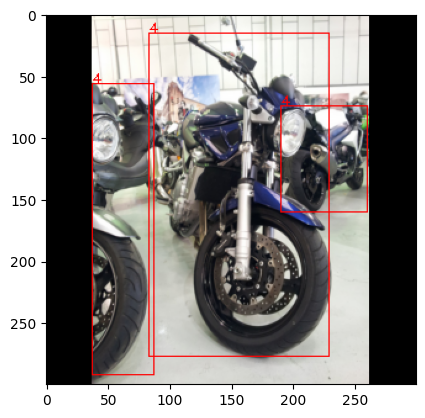

In [32]:
image_index = 6

np_image = images[image_index, ...].permute((1, 2, 0)).cpu().numpy()
np_image *= 255
np_image = np_image.astype(np.uint8).copy()

for obj in objects[image_index]:
    cx = obj[1] * np_image.shape[1]
    cy = obj[2] * np_image.shape[0]
    w = obj[3] * np_image.shape[1]
    h = obj[4] * np_image.shape[0]

    left = int(cx - w/2)
    right = int(cx + w/2)
    top = int(cy - h/2)
    bottom = int(cy + h/2)

    class_id = int(obj[0])

    np_image = cv2.rectangle(np_image, (left, top), (right, bottom), (255, 0, 0), 1)
    np_image = cv2.putText(np_image, f"{class_id}", (left, top), 0, 0.4, (255, 0, 0), 1)


plt.imshow(np_image)

In [ ]:
# # Zero the gradients - this is required on each mini-batch
optimiser.zero_grad()